## War Thunder - analiza Twittera

War Thunder to darmowa gra o czołgach, samolotach i okrętach wojennych. Wielokrotnie wzbudzała kontrowersje związane między innymi z ujawnianiem tajnych dokumentów dotyczących pojazdów znajdujących się w grze. Jednak dosłownie w ostatnich dniach rozwinęła się jedna z największych kontrowersji związana z protestem graczy wobec ekonomii w grze. 

Postaramy się sprawdzić, czy ten nowy trend pojawia się w tweetach.

### Pozyskanie tweetów

Deklarujemy kilka elementów istotnych w dalszej części - SIA dla Vader, listę wszystkich słów oraz stopwords. Następnie przechodzimy do funkcji.

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

all_words = []

stop_words = set(stopwords.words('english'))
stop_words.add('say')
stop_words.add('says')
stop_words.add('said')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adamz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
from nltk.stem import WordNetLemmatizer
import text2emotion as te

def get_scores(tweet):
    vader_scores = sia.polarity_scores(tweet)
    text_scores = te.get_emotion(tweet)

    return (vader_scores, text_scores)

#### get_scores

Prosta funkcja, która pozwala nam pozyskać wyniki analizy dla naszych bibliotek - Vader i Text2Emotion.

In [21]:
import re

def process_raw_content(raw_content):
    tokens = raw_content.split()

    filtered = [re.sub(r'[,.:#?_"\-!0-9\\\\].*', '', w.lower()) for w in tokens if not re.sub(r'[,.:#?_"\-!0-9\\\\].*', '', w.lower()) in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in filtered]
    lemmatized = list(filter(None, lemmatized))

    all_words.extend(lemmatized)

    modified_content = ' '.join(lemmatized)
    return modified_content

#### process_raw_content

Ta funkcja filtruje i lematyzuje text tweeta. Nasz (zadeklarowany wcześniej) zestaw stop words jest wykorzystany aby usunąć niepotrzebne słowa, poza tym usuwamy niepotrzebne znaki typu ", !, : itp. Następnie lematyzujemy pozostały tekst i dodatkowo dodajemy słowa do listy wszystkich słów, którą później wykorzystamy do dalszej analizy.

In [22]:
import html

def transform_tweet(tweet):
    date, raw_content, reply_count, retweet_count, like_count = tweet

    date_str = date.strftime("%d.%m.%Y")

    raw_content = raw_content.encode('unicode_escape').decode()
    emoji_regex = re.compile("[\U00010000-\U0010ffff]")
    raw_content = emoji_regex.sub(lambda match: f'_{match.group()}_', raw_content)
    
    url_regex = re.compile(r'https?://[^\s]+')
    mention_regex = re.compile(r'@\w+')
    raw_content = mention_regex.sub('', raw_content)
    raw_content = url_regex.sub('', raw_content)

    raw_content = re.sub(r'(\\[rn])+', '\n', raw_content)

    raw_content = html.unescape(raw_content)

    modified_content = process_raw_content(raw_content)
    scores = get_scores(modified_content)

    return (modified_content, date_str, reply_count, retweet_count, like_count, scores[0], scores[1])

#### transform_tweet

Ta funkcja powstała wcześnie w developmencie więc jest trochę chaotyczna. Ona ma za zadanie zrobić pierwsze kroki pre-processingu, takie jak usuwanie linków i emoji (niestety nie udało mi się ich zachować do analizy), i wywołanie poprzednio opisanej *process_raw_content*. Następnie zwraca ona tuple, który będzie zapisany w csv.

In [23]:
import csv

def write_tweets_to_csv(tweets, filename):
    counter = 0
    unique_content = set()

    with open(filename, mode='w', encoding='utf-8', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        writer.writerow(['Modified Content', 'Date', 'Reply Count', 'Retweet Count', 'Like Count', 'Vader Score', 'Text2Emotion Score'])

        for tweet in tweets:
            fixed_tweet = transform_tweet(tweet)
            modified_content, date, reply_count, retweet_count, like_count, vader_score, text_score = fixed_tweet

            # Check if tweet with the same raw content has already been written
            if modified_content not in unique_content:
                counter += 1
                writer.writerow([modified_content, date, reply_count, retweet_count, like_count, vader_score, text_score])
                unique_content.add(modified_content)

    print(counter)

#### write_tweets_to_csv

Ta funkcja ma za zadanie zapisać tweety do pliku csv. Jej dodatkowym zadaniem jest podstawowe wykrywanie i usuwanie spamu poprzez ignorowanie identycznych tweetów.

In [24]:
import snscrape.modules.twitter as sn

tweets_list = []
max_tweets = 30000

counter = 0
for i,tweet in enumerate(sn.TwitterSearchScraper("WarThunder since:2023-04-19 lang:en").get_items()):
    if i > max_tweets:
        break

    tweetie = (tweet.date, tweet.rawContent, tweet.replyCount, tweet.retweetCount, tweet.likeCount)
    tweets_list.append(tweetie)
    counter += 1
    if counter % 1000 == 0:
        print(counter / 200)

counter = 0
for i,tweet in enumerate(sn.TwitterSearchScraper("WarThunder since:2022-01-01 until:2023-04-19 lang:en").get_items()):
    if i > max_tweets:
        break

    tweetie = (tweet.date, tweet.rawContent, tweet.replyCount, tweet.retweetCount, tweet.likeCount)
    tweets_list.append(tweetie)
    counter += 1
    if counter % 1000 == 0:
        print(counter / 200)

write_tweets_to_csv(tweets_list, "tweets.csv")

import json
import gzip

with gzip.open('all_words.json.gz', 'wt') as file:
    json.dump(all_words, file)

5.0
10.0
15.0


Could not translate t.co card URL on tweet 1659273739933032463


20.0
25.0
30.0


Could not translate t.co card URL on tweet 1656864464564637696


35.0
40.0


Unavailable user in card on tweet 1655452510096883712
Unavailable user in card on tweet 1655452510096883712
User 1595609128453275648 not found in user refs in card on tweet 1655452510096883712
User 1595609128453275648 not found in user refs in card on tweet 1655452510096883712


45.0
50.0
55.0


Could not translate t.co card URL on tweet 1653056209597915141


60.0
65.0
70.0


Stopping after 20 empty pages
Could not translate t.co card URL on tweet 1648310991027937284
Could not translate t.co card URL on tweet 1647334129539874816


5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0


Could not translate t.co card URL on tweet 1639342143633252364
Could not translate t.co card URL on tweet 1638644337465520131


55.0


Could not translate t.co card URL on tweet 1637648505148932096


60.0


Could not translate t.co card URL on tweet 1637098315589492742
Could not translate t.co card URL on tweet 1636743286403780611


65.0
70.0
75.0
80.0


Could not translate t.co card URL on tweet 1633207175676821505


85.0
90.0
95.0
100.0


Twitter responded with an error: TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecif

105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
38702


Między liniami pokazującymi progress (gdyby przypadkiem coś się zacięło w ponad godzinie pracy programu) pojawia się kilka problemów, ale dotyczą one pojedynczych tweetów z ponad 38 000. Z tego powodu zignorowanie ich wydaje się być najlepszym wyborem.

#### Reszta kodu

Z funkcjami opisanymi powyżej wykorzystujemy snscrape aby pobrać tweety, a następnie przerobić je i zapisać do pliku csv. Z jakiegoś powodu u mnie pojawił się dziwny cut-off 19.04.2023, więc musiałem rozdzielić to na dwie pętle. Zapisujemy tu również naszą listę wszystkich słów.

Po tym wszystkim dostajemy wynik w takiej formie:
| Modified Content | Date | Reply Count | Retweet Count | Like Count | Vader Score | Text2Emotion Score |
|------------------|------|-------------|---------------|------------|-------------|-----------------------------------------------------|
| man hope get shit together want war thunder shutting | 23.05.2023 | 0 | 0 | 0 | "{'neg': 0.449, 'neu': 0.299, 'pos': 0.251, 'compound': -0.6486}" | "{'Happy': 0.0, 'Angry': 0.33, 'Surprise': 0.33, 'Sad': 0.0, 'Fear': 0.33}" |

## Wizualizacja i analiza

Orginalnie to był osobny plik, więc niektóre rzeczy mogą się trochę powtarzać.

Mając dane przerobione i zapisane, możemy zacząć wizualizację i analizę. Najpierw deklarujemy listę dla wszystkich słów oraz wczytujemy dane z plików.

In [38]:
import pandas as pd
import json
import gzip

all_words = []

with gzip.open('all_words.json.gz', 'rt') as file:
        all_words = json.load(file)

df = pd.read_csv('tweets.csv')

Następnie zaczynamy z danymi odnośnie tonu emocjonalnego tweetów.

In [39]:
import ast

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df['Vader Score'] = df['Vader Score'].apply(lambda x: ast.literal_eval(x))
df['Text2Emotion Score'] = df['Text2Emotion Score'].apply(lambda x: ast.literal_eval(x))

df['Vader Pos'] = df['Vader Score'].apply(lambda x: x['pos'])
df['Vader Neg'] = df['Vader Score'].apply(lambda x: x['neg'])
df['Vader Neu'] = df['Vader Score'].apply(lambda x: x['neu'])
df['Vader Compound'] = df['Vader Score'].apply(lambda x: x['compound'])

df['Text2Emotion Happy'] = df['Text2Emotion Score'].apply(lambda x: x['Happy'])
df['Text2Emotion Angry'] = df['Text2Emotion Score'].apply(lambda x: x['Angry'])
df['Text2Emotion Sad'] = df['Text2Emotion Score'].apply(lambda x: x['Sad'])
df['Text2Emotion Fear'] = df['Text2Emotion Score'].apply(lambda x: x['Fear'])
df['Text2Emotion Surprise'] = df['Text2Emotion Score'].apply(lambda x: x['Surprise'])

df_grouped = df.groupby(df['Date'].dt.date).mean()



C:\Users\adamz\AppData\Local\Temp\ipykernel_13920\866960366.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(df['Date'].dt.date).mean()


### Ton emocjonalny

Aby zrobić wykresy najpierw wyciągamy dane dla każdego "humoru" . Następnie grupujemy je po datach i wyświetlamy.

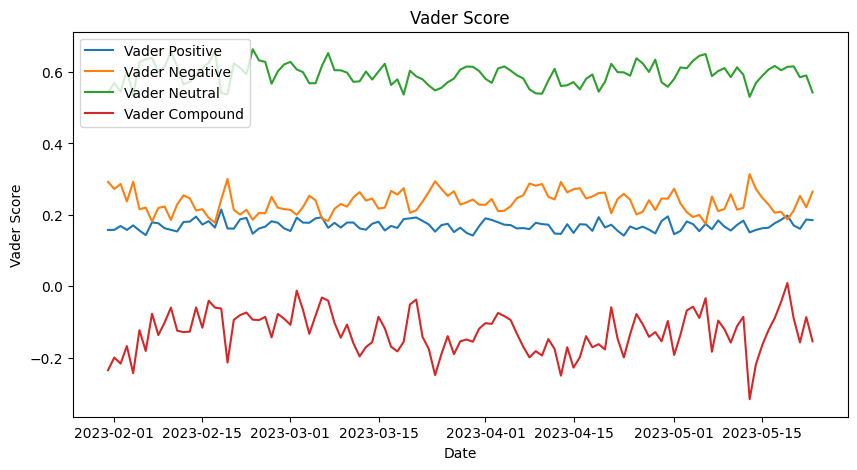

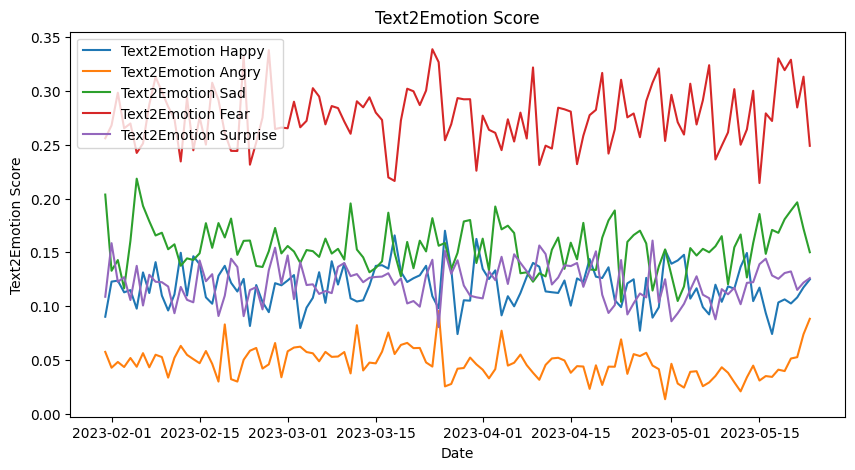

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_grouped.index, df_grouped['Vader Pos'], label='Vader Positive')
plt.plot(df_grouped.index, df_grouped['Vader Neg'], label='Vader Negative')
plt.plot(df_grouped.index, df_grouped['Vader Neu'], label='Vader Neutral')
plt.plot(df_grouped.index, df_grouped['Vader Compound'], label='Vader Compound')
plt.xlabel('Date')
plt.ylabel('Vader Score')
plt.title('Vader Score')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_grouped.index, df_grouped['Text2Emotion Happy'], label='Text2Emotion Happy')
plt.plot(df_grouped.index, df_grouped['Text2Emotion Angry'], label='Text2Emotion Angry')
plt.plot(df_grouped.index, df_grouped['Text2Emotion Sad'], label='Text2Emotion Sad')
plt.plot(df_grouped.index, df_grouped['Text2Emotion Fear'], label='Text2Emotion Fear')
plt.plot(df_grouped.index, df_grouped['Text2Emotion Surprise'], label='Text2Emotion Surprise')
plt.xlabel('Date')
plt.ylabel('Text2Emotion Score')
plt.title('Text2Emotion Score')
plt.legend(loc='upper left')
plt.show()

Te wykresy nie są zbyt przejrzyste. Widać jeden wyraźny spadek i jeden wzrost w *compound* dla Vader, ale poza tym wyniki są trudne do analizy. Spróbujmy to poprawić. Tym razem wyświetlimy dane w formacie (POZYTYWNE EMOCJE - NEGATYWNE EMOCJE) / NEUTRALNE EMOCJE.

C:\Users\adamz\AppData\Local\Temp\ipykernel_13920\4247956334.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(df['Date'].dt.date).mean()


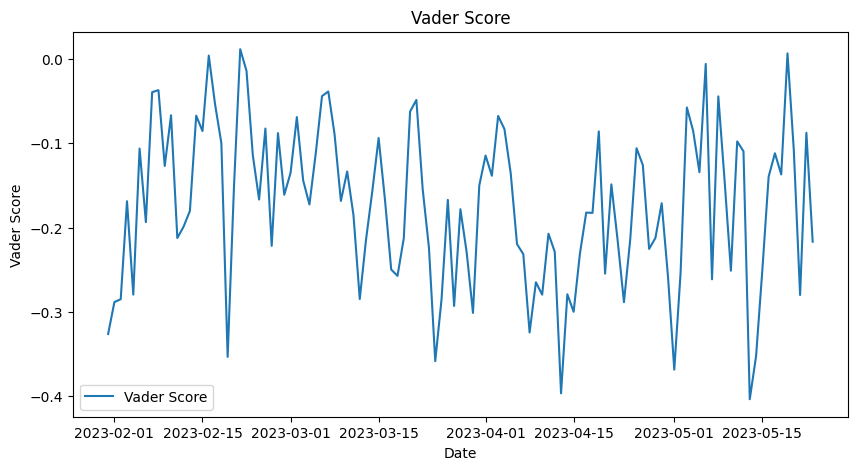

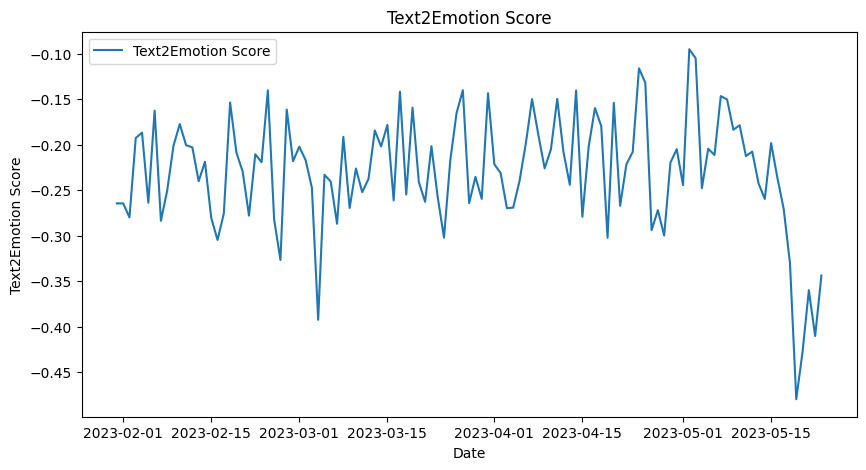

In [34]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

df = pd.read_csv('tweets.csv')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df['Vader Score'] = df['Vader Score'].apply(
    lambda x: ast.literal_eval(x))

df['Vader Score'] = df['Vader Score'].apply(
    lambda x: (x['pos'] - x['neg']) / x['neu'] if x['neu'] != 0 else 0)

df['Text2Emotion Score'] = df['Text2Emotion Score'].apply(lambda x: ast.literal_eval(x))

df['Text2Emotion Score'] = df['Text2Emotion Score'].apply(
    lambda x: (x['Happy'] - x['Angry'] - x['Sad'] - x['Fear']) / x['Surprise'] if x['Surprise'] != 0 else 0)

df_grouped = df.groupby(df['Date'].dt.date).mean()

plt.figure(figsize=(10, 5))
plt.plot(df_grouped.index, df_grouped['Vader Score'], label='Vader Score')
plt.xlabel('Date')
plt.ylabel('Vader Score')
plt.title('Vader Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_grouped.index, df_grouped['Text2Emotion Score'], label='Text2Emotion Score')
plt.xlabel('Date')
plt.ylabel('Text2Emotion Score')
plt.title('Text2Emotion Score')
plt.legend()
plt.show()

Tym razem widać trochę więcej. Vader jest dość chaotyczny, ale Text2Emotion ma wyraźne spadki, które pokrywają się mniej więcej z wydarzeniami związanymi z grą. Około 2023-03-05 wyszła wersja mobilna War Thundera co na pewno nie spodobało się części fanów. Jednak znacznie bardziej wyróżniają się ostatnie dni, kiedy zaczęły się "strajki" graczy. Jest to bardzo wyraźny spadek.

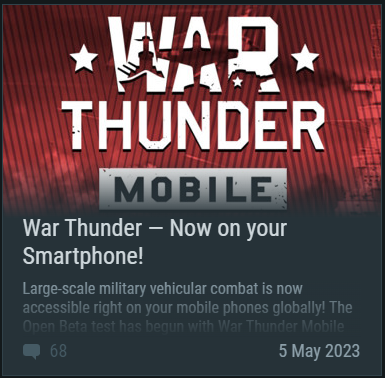
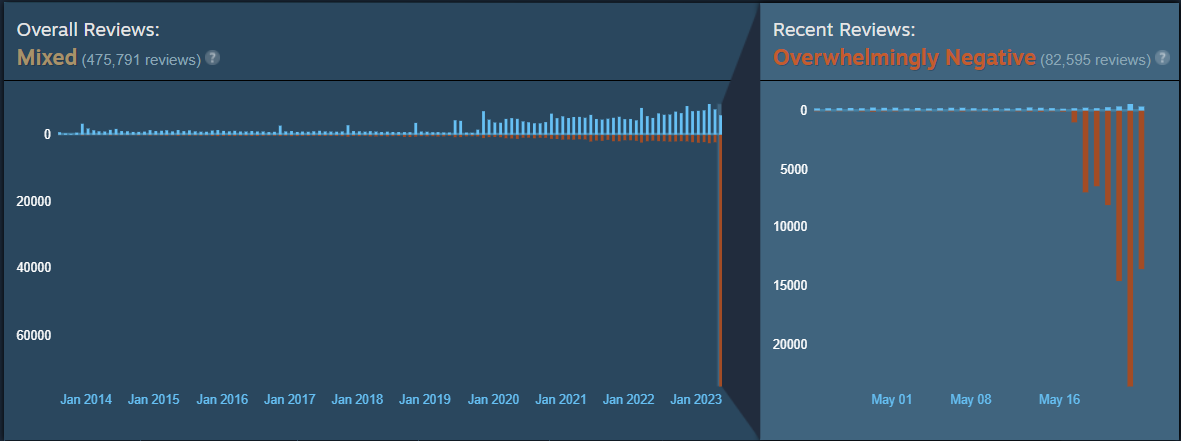

### Zainteresowanie

Poza nastrojem chciałem jeszcze wykorzystać dane dotyczące ilości odpowiedzi/lików/retweetów. Poniżej jest to zrobione, ponownie pogrupowane po dacie.

C:\Users\adamz\AppData\Local\Temp\ipykernel_13920\588757599.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sum = df.groupby(df['Date'].dt.date).sum()


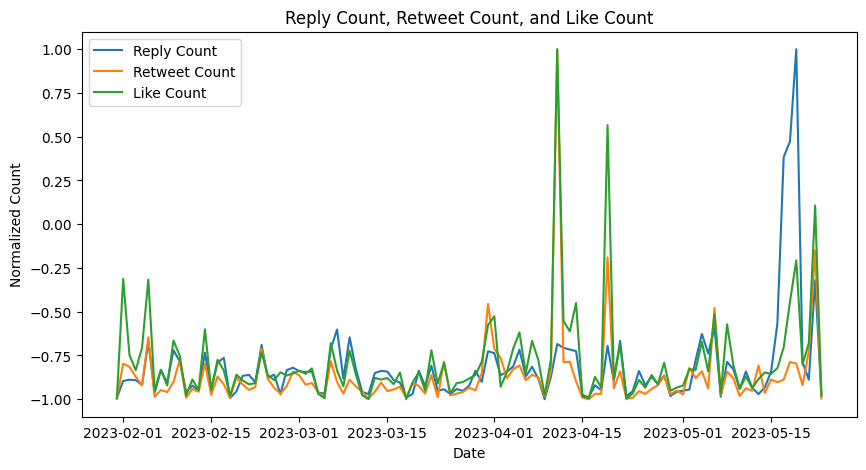

In [28]:
df_sum = df.groupby(df['Date'].dt.date).sum()

df_sum['Reply Count'] = 2 * (df_sum['Reply Count'] - df_sum['Reply Count'].min()) / (
        df_sum['Reply Count'].max() - df_sum['Reply Count'].min()) - 1

df_sum['Retweet Count'] = 2 * (df_sum['Retweet Count'] - df_sum['Retweet Count'].min()) / (
        df_sum['Retweet Count'].max() - df_sum['Retweet Count'].min()) - 1

df_sum['Like Count'] = 2 * (df_sum['Like Count'] - df_sum['Like Count'].min()) / (
        df_sum['Like Count'].max() - df_sum['Like Count'].min()) - 1

plt.figure(figsize=(10, 5))
plt.plot(df_sum.index, df_sum['Reply Count'], label='Reply Count')
plt.plot(df_sum.index, df_sum['Retweet Count'], label='Retweet Count')
plt.plot(df_sum.index, df_sum['Like Count'], label='Like Count')
plt.xlabel('Date')
plt.ylabel('Normalized Count')
plt.title('Reply Count, Retweet Count, and Like Count')
plt.legend()
plt.show()

Poraz kolejny widzimy, że wersja mobilna i niedawne wydarzenia stworzyły eksplozję aktywności.

### Najczęściej występujące słowa

Dodatkowo pokazujemy najczęściej występujące słowa i wordcloud.

Word count: 411499


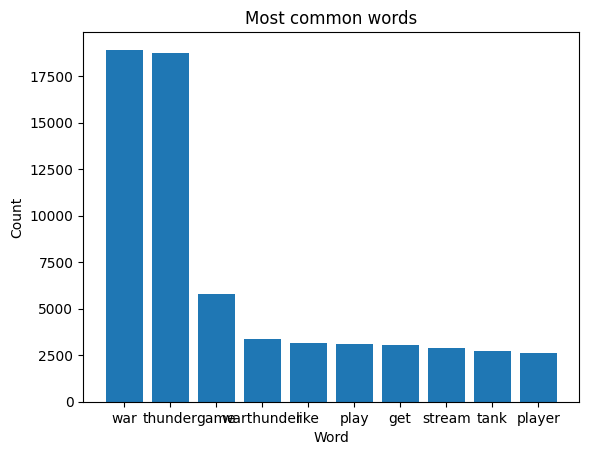

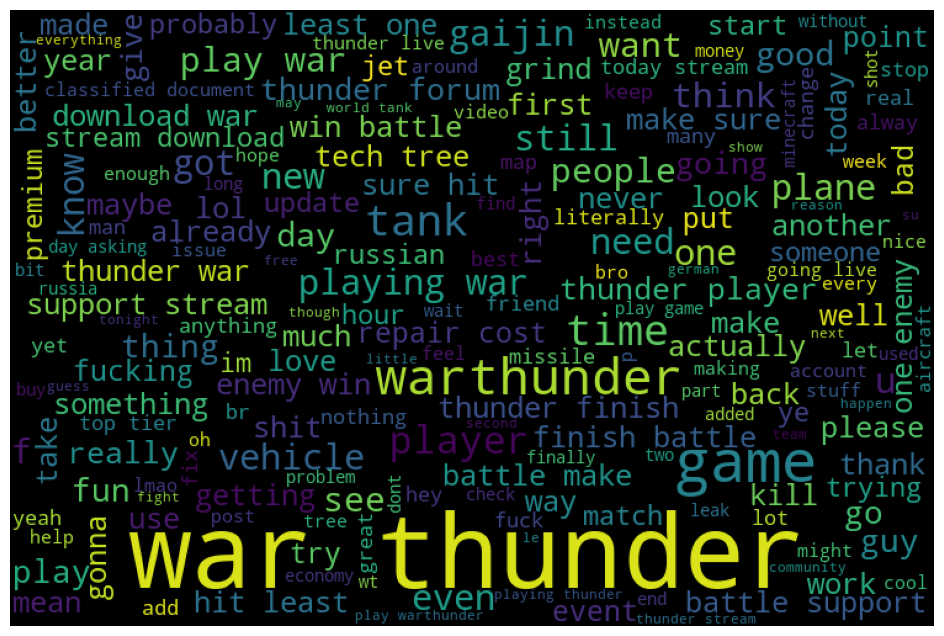

In [29]:
from collections import Counter
from wordcloud import WordCloud

print("Word count: " + str(len(all_words)))

word_counts = Counter(all_words)

top_words = word_counts.most_common(10)

words_list = [x[0] for x in top_words]
counts_list = [x[1] for x in top_words]

plt.bar(words_list, counts_list)
plt.title('Most common words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

bigstring = (" ").join(all_words)

wordcloud = WordCloud(width = 750, height = 500).generate(bigstring)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

Co do najczęściej występujących słów, nie ma zaskoczenia. Nazwa gry, czołgi, streamy, itp.

Teraz to samo dla negatywnych i pozytywnych tweetów:

{'Modified Content': 'rare chance played warthunder really fun game would awesome could use link try play match sure hit least enemy match bonus win match help support channel', 'Date': '13.02.2023', 'Reply Count': '0', 'Retweet Count': '0', 'Like Count': '1', 'Vader Score': "{'neg': 0.0, 'neu': 0.317, 'pos': 0.683, 'compound': 0.9839}", 'Text2Emotion Score': "{'Happy': 0.17, 'Angry': 0.17, 'Surprise': 0.17, 'Sad': 0.0, 'Fear': 0.5}"}
0.9839
{'Modified Content': "heart attack game i'll hate rest life fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck", 'Date': '02.05.2023', 'Reply Count': '0', 'Retweet Count': '0', 'Like Count': '1', 'Vader Score': "{'neg': 0.93, 'neu': 0.07, 'pos': 0.0, 'compound': -0.9967}", 'Text2Emotion Score': "{'Happy': 0.85, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.1, 'Fear': 0.05}"}
-0.9967
POSITIVE
Word count: 10203


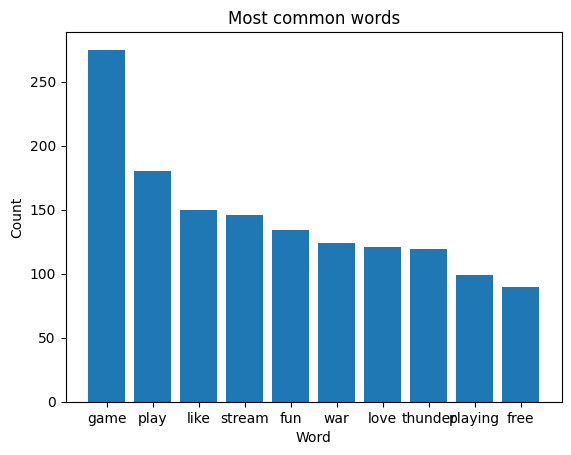

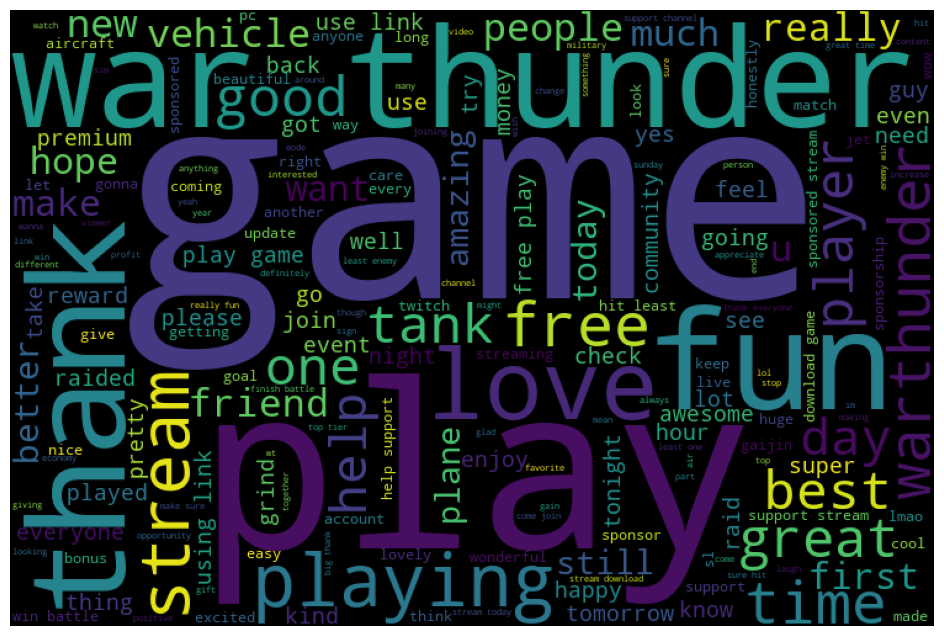

NEGATIVE
Word count: 372229


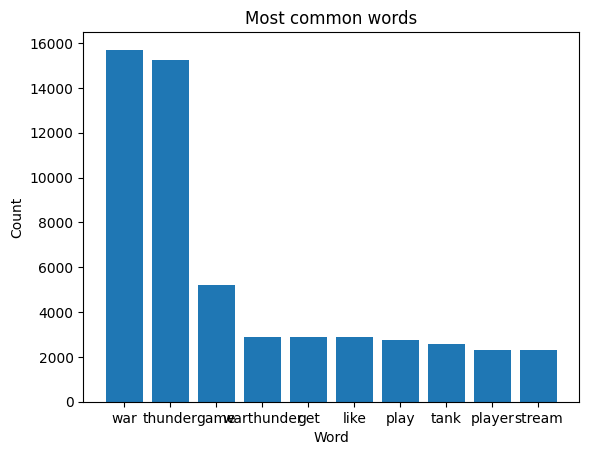

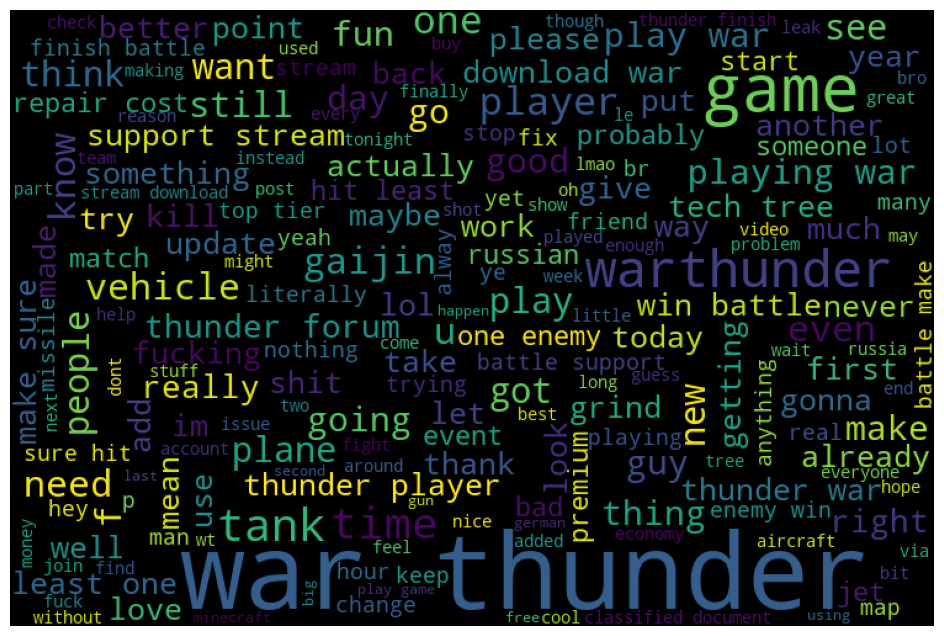

In [9]:
import csv
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

with open('tweets.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)

def calculate_score(row):
    score_dict = eval(row['Vader Score'])
    return score_dict['compound']

sorted_data = sorted(data, key=calculate_score, reverse=True)

print(sorted_data[0])
print(calculate_score(sorted_data[0]))
print(sorted_data[len(sorted_data) - 1])
print(calculate_score(sorted_data[len(sorted_data) - 1]))

top_half = sorted_data[:500]
bottom_half = sorted_data[500:]

def extract_words(text):
    return text.split()

top_words = [word for row in top_half for word in extract_words(row['Modified Content'])]
bottom_words = [word for row in bottom_half for word in extract_words(row['Modified Content'])]

def displayData(words):
    print("Word count: " + str(len(words)))

    word_counts = Counter(words)

    top_words = word_counts.most_common(10)

    words_list = [x[0] for x in top_words]
    counts_list = [x[1] for x in top_words]

    plt.bar(words_list, counts_list)
    plt.title('Most common words')
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.show()

    bigstring = (" ").join(words)

    wordcloud = WordCloud(width = 750, height = 500).generate(bigstring)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("your_file_name"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

print('POSITIVE')
displayData(top_words)
print('NEGATIVE')
displayData(bottom_words)

## Wnioski

Vader wydaje się być mniej skuteczny niż Text2Emotion, chociaż wartość *compound* wydaje się pokazywać podobne wyniki co nasza interpretacja danych z T2E. Wyraźnie widać spadki kiedy pojawia się kontrowersja o grze. Mniej wyróżniają się pozytywne momenty, jednak może to wynikać z dwóch powodów:
1. Gra jest dość kontrowersyjna, więc dla każdego pozytywnego tweeta pojawia się negatywny.
2. Updaty pojawiają się często, więc zawsze jest o czym mówić, czym się ekscytować - więc emocje pozostają na stabilnym, dość wysokim poziomie.

Ciekawy jest też ogólny wzrost aktywności w tych momentach. Jest to oczywiście coś czego można się było spodziewać.